# HW 5 Template

This code may (or may not!) be helpful in your Fourth assignment.  Feel free to use it (or not).

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

This section provides some initialization commands, which can simply be copied for assignments.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# We need to import key libraries that we're going to use.  
# For now this is just numpy, which is our linear algebra library
import numpy as np

Setting the random seed for code reproducibility.

In [2]:
# to make this notebook's output stable across runs, we are going to see the random seed
np.random.seed(42)

Note that we have to reset the random seed _every_ time we run an algorithm if we want the same results!

We also want to set up a plotting environment and make it look pretty.  For those of you familiar with matlab, we will be using matplotlib which is fairly close in syntax and feel.  It's not too far off from R either.

In [3]:
# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline 
# This command figures show up in the notebook.  It's a "magic" command...
# Typically, this now happens by default so it is often an unnecessary command, but is good for standardization.
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

These commands will help us save figures; not going to go through them so much.

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "hw5"

In [5]:
# makes the directory if it doesn't exist.
import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn\'t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

Figure directory exists.


In [6]:
# a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

## Problem 1, Southern Oscillation Index

In [7]:
import pandas as pd
data=pd.read_csv('data/soi.txt',sep='  ',header=2,index_col=0)
data=data[0:67]
x=np.double(data.values.reshape([-1]))
t=np.arange(0,67,1./12.)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Text(0, 0.5, 'SOI')

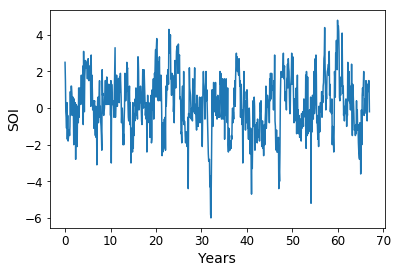

In [8]:
fig=plt.figure()
plt.plot(t,x)
plt.xlabel('Years')
plt.ylabel('SOI')

#### filtering data

In [9]:
from scipy import signal

In [10]:
# Filter specifications.
order = 4 # Order
sampling_rate = 1/(t[1]-t[0]) # in times per years
cutoff = 2 # desired cutoff frequency of the filter, inverse years

In [11]:
print('Our sampling rate is {} times yearly.'.format(sampling_rate))

Our sampling rate is 12.0 times yearly.


In [12]:
# helper function to put things in more understandable units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

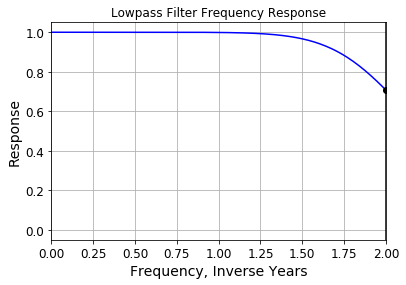

In [13]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, sampling_rate, order)
# Plot the frequency response.
w, h = signal.freqz(b, a)
fig=plt.figure()
plt.plot(0.5*sampling_rate*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 2)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency, Inverse Years')
plt.ylabel('Response')
plt.grid()
plt.show()
# savepdf(fig,'freq_response')

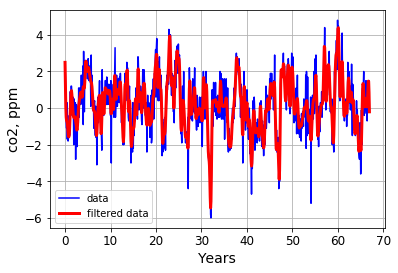

In [14]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

x_filtered = butter_lowpass_filter(x, cutoff, sampling_rate, order)
fig=plt.figure()
plt.plot(t, x, 'b-', label='data')
plt.plot(t, x_filtered, 'r-', linewidth=3, label='filtered data')
plt.xlabel('Years')
plt.ylabel('co2, ppm')
plt.grid()
plt.legend()
plt.show()
# savepdf(fig,'filtered_data')

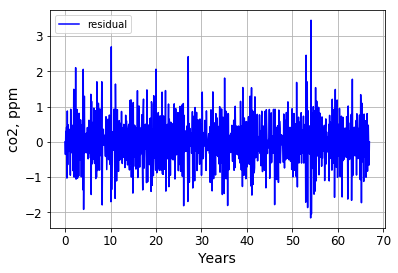

In [15]:
fig=plt.figure()
plt.plot(t, x_filtered-x, 'b-', label='residual')
plt.xlabel('Years')
plt.ylabel('co2, ppm')
plt.grid()
plt.legend()
plt.show()
# savepdf(fig,'filtered_residual')

In [16]:
x_fft=np.fft.fft(x_filtered)
freqs = np.fft.fftfreq(x_filtered.size, t[1]-t[0])

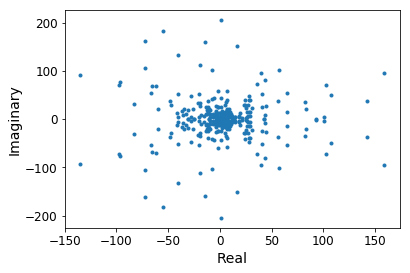

In [17]:
fig=plt.figure()
plt.plot(np.real(x_fft[1:]),np.imag(x_fft[1:]),'.')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()
savepdf(fig,'x_fft')

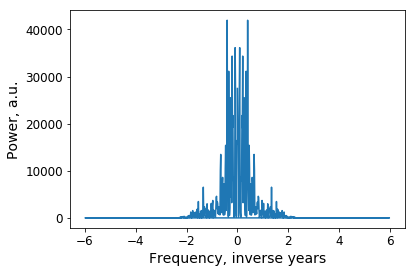

In [18]:
fig=plt.figure()
plt.plot(freqs,np.abs(x_fft)**2)
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.show()

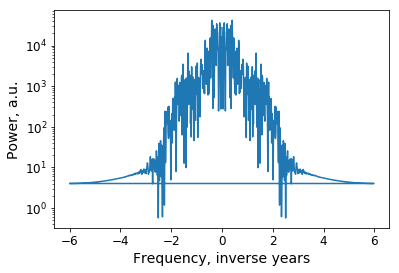

In [19]:
fig=plt.figure()
plt.semilogy(freqs,np.abs(x_fft)**2)
plt.xlabel('Frequency, inverse years')
plt.ylabel('Power, a.u.')
plt.show()

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Figure(432x288)


Text(0.5, 0, 'number of lags')

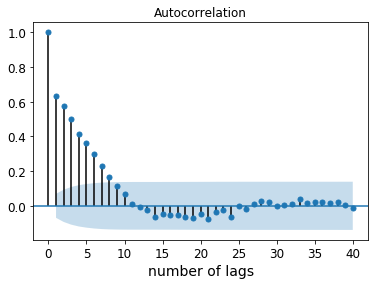

In [21]:
print(plot_acf(x, lags=40))
plt.xlabel('number of lags')

Figure(432x288)


Text(0.5, 0, 'number of lags')

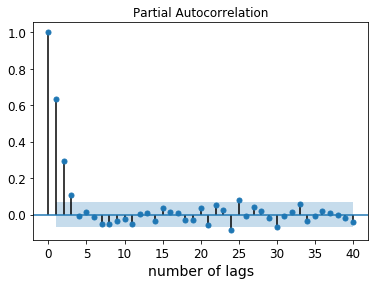

In [22]:
print(plot_pacf(x, lags=40))
plt.xlabel('number of lags')

## Problem 2, Forecasting in the Southern Oscillation Index

Not much in the way of setup is necessary here.

In [23]:
from sklearn import metrics,linear_model, neighbors, model_selection, preprocessing, pipeline
from statsmodels.tsa import ar_model
KFold=model_selection.KFold(n_splits=4,random_state=10,shuffle=True)

In [24]:
# a helper function for time series validation
# @return MSE, STD_ERROR
def time_series_valid(X, y, model):
    normalizer=preprocessing.StandardScaler()
    pipe=pipeline.Pipeline([('norm',normalizer),('model',model)])
    TSS=model_selection.TimeSeriesSplit(n_splits=10)
    scores=[]
    for train_ndx,valid_ndx in TSS.split(X,y):
        valid_ndx_adjusted=valid_ndx
        pipe.fit(X[train_ndx],y[train_ndx])
        score=(metrics.mean_squared_error\
          (y[valid_ndx_adjusted],pipe.predict(X[valid_ndx_adjusted])))
        scores.append(score)
    # print('Average MSE of {0} with a standard error of {1}'.format(np.mean(scores),np.std(scores)/np.sqrt(KFold.n_splits)))
    explained_variance=1-np.mean(scores)/metrics.mean_squared_error(np.mean(y).repeat(y.shape),y)
    return np.mean(scores), np.std(scores)/np.sqrt(KFold.n_splits), explained_variance

### knn model

In [25]:
# k-Nearest Neighbor model to forecast one step ahead on the raw data
N_neighbor = 40
N_lag = 30
n_max=len(x)
knn_scores=np.zeros([N_lag-1, N_neighbor-1])
for l in range(1, N_lag):
    for n in range(1, N_neighbor):
        knn=neighbors.KNeighborsRegressor(n_neighbors=n)
        # Construct our new 'X' matrix
        X=np.zeros([n_max-l, l])
        for i in range(0, n_max-l):
            X[i]=x[i:i+l]
        y=x[l:]
        mse, std_err, explained_variance = time_series_valid(X, y, knn)
        knn_scores[l-1, n-1] = mse

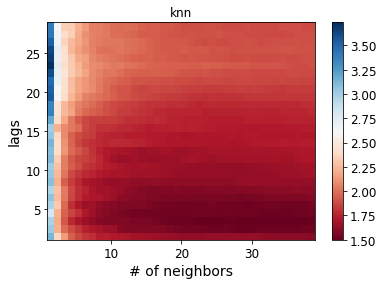

In [26]:
# (a) plot the result
fig=plt.figure(figsize=[6,4])
neighbor_range = np.arange(1, N_neighbor)
lag_range = np.arange(1, N_lag)
ax = plt.gca()
c = ax.pcolormesh(neighbor_range, lag_range,  knn_scores, cmap='RdBu')
fig.colorbar(c, ax=ax)
plt.xlabel('# of neighbors')
plt.ylabel('lags')
plt.title('knn')
plt.axis('tight')
plt.show()

In [27]:
ind = np.unravel_index(np.argmin(knn_scores, axis=None), knn_scores.shape)
print("select {} lags and {} neighbors".format(lag_range[ind[0]], neighbor_range[ind[1]]))

select 3 lags and 32 neighbors


### Autoregressive

In [28]:
# re-use hw4 linear model to do autoregressive model prediction
lin_reg=linear_model.LinearRegression()
max_lags=50
lin_scores=np.zeros([max_lags-1])
for n_lag in range(1, max_lags):
    # Construct our new 'X' matrix
    n_max=len(x)
    X=np.zeros([n_max-n_lag, n_lag])
    for i in range(0, n_max-n_lag):
        X[i]=x[i:i+n_lag]
    y=x[n_lag:]
    mse, std_err, explained_variance = time_series_valid(X, y, lin_reg)
    lin_scores[n_lag-1]=mse

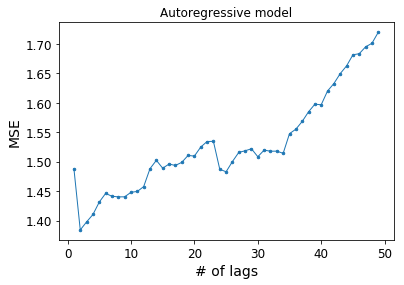

In [29]:
# (a) plot the result
fig=plt.figure()
plt.plot(range(1, max_lags),lin_scores,'.-',lw=1,ms=5)
plt.xlabel('# of lags')
plt.ylabel('MSE')
plt.title('Autoregressive model')
plt.show()

In [30]:
idx = np.argmin(lin_scores)
print("the best number of lags is {}, with MSE at {}".format(idx+1, lin_scores[idx]))

the best number of lags is 2, with MSE at 1.3840202202889473
